# Задание
* Выполнить исследование и сравнительный анализ возможностей RNN, LSTM, GRU на примере предлагаемого кода.
* Сравнить полученные нейронные сети по Accuracy, Precision, Recall,
F1, Loss на train и test.
* Выполнить исследования на примере фрагмента кода с заменой
LSTM на RNN и GRU.
* Исследовать, как определяется число параметров Param в каждом
слое.
* Изучить и описать назначение используемых методов и параметров.
* Вывести графические зависимости для Loss и Accuracy на train и
val (на обучающей и валидационной подвыборках).
* Оценить время разработки классификаторов с CPU.
* Оценить время разработки классификаторов с GPU (в Google
Colab).

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Activation
import seaborn as sns
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
np.random.seed(1234)  
PYTHONHASHSEED = 0

Загружаем датасет.

In [1]:
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt

--2020-05-25 14:24:21--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.10, 2620:1ec:bdf::10
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt’

PM_train.txt        100%[===================>]   3.35M  5.02MB/s    in 0.7s    

2020-05-25 14:24:22 (5.02 MB/s) - ‘PM_train.txt’ saved [3515356/3515356]

--2020-05-25 14:24:23--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.10, 2620:1ec:bdf::10
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt’

PM_test.txt         100%[===================>]   2.

In [0]:
# чтение тренировочных данных 
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# чтение тестовых данных
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# чтение "истинных" данных
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)                                         

In [5]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Предобработка данных

In [6]:
# Создаём столбец RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [7]:
# Генерируем метки для обучающих данных
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [8]:
# Нормализуем данные
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [9]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [10]:
# Создаём колонку "максимальных" значений для тестовых данных
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# Создаём столбец RUL для тестовых данных
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [11]:
# Создаём метки для столбцов w0 и w1
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


## Моделирование

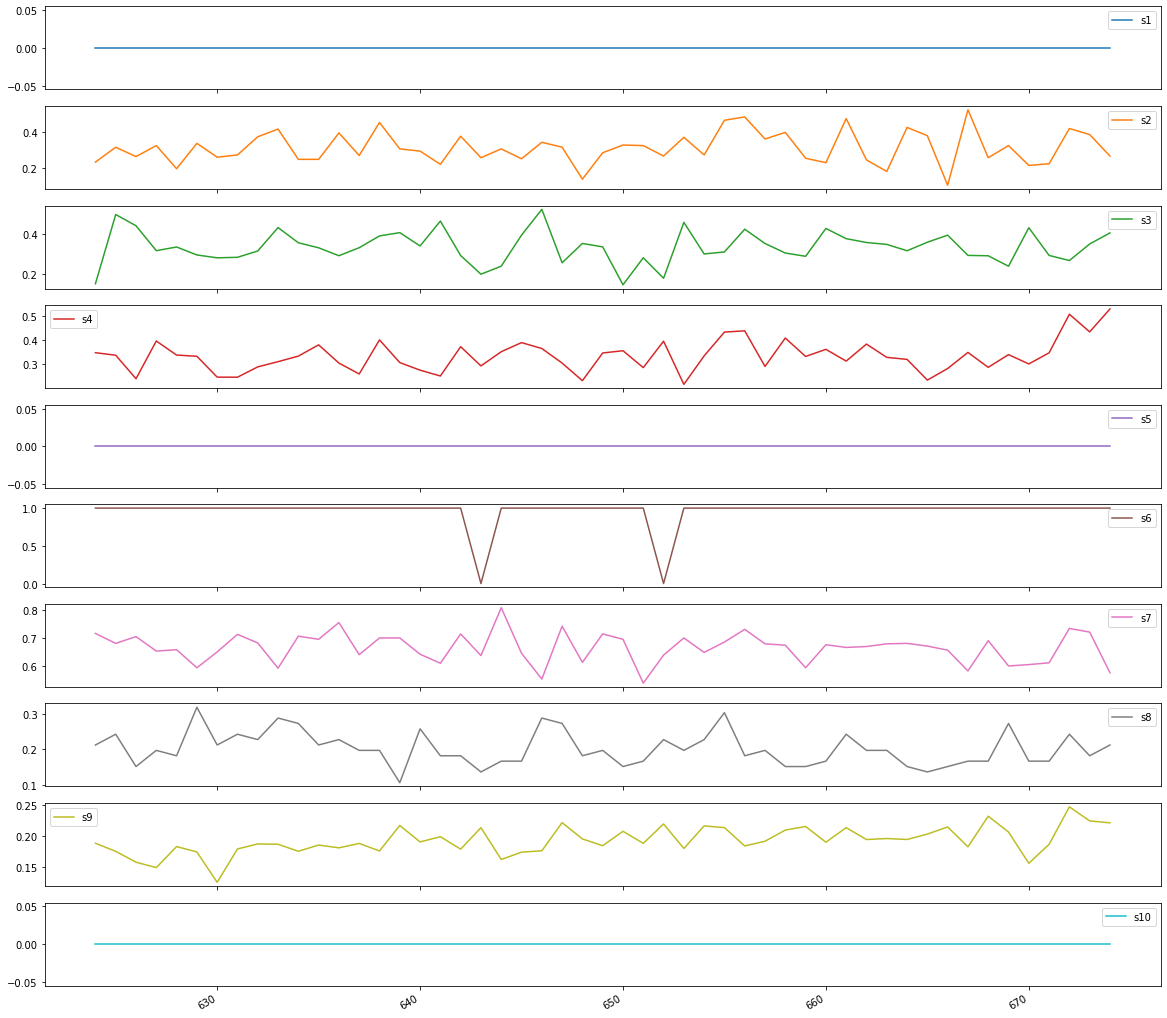

In [12]:
sequence_length = 50
engine_id7 = test_df[test_df['id'] == 7]
engine_id7_50cycleWindow = engine_id7[engine_id7['RUL'] <= engine_id7['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id7_50cycleWindow1 = engine_id7_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id7_50cycleWindow2 = engine_id7_50cycleWindow[cols2]

ax1 = engine_id7_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

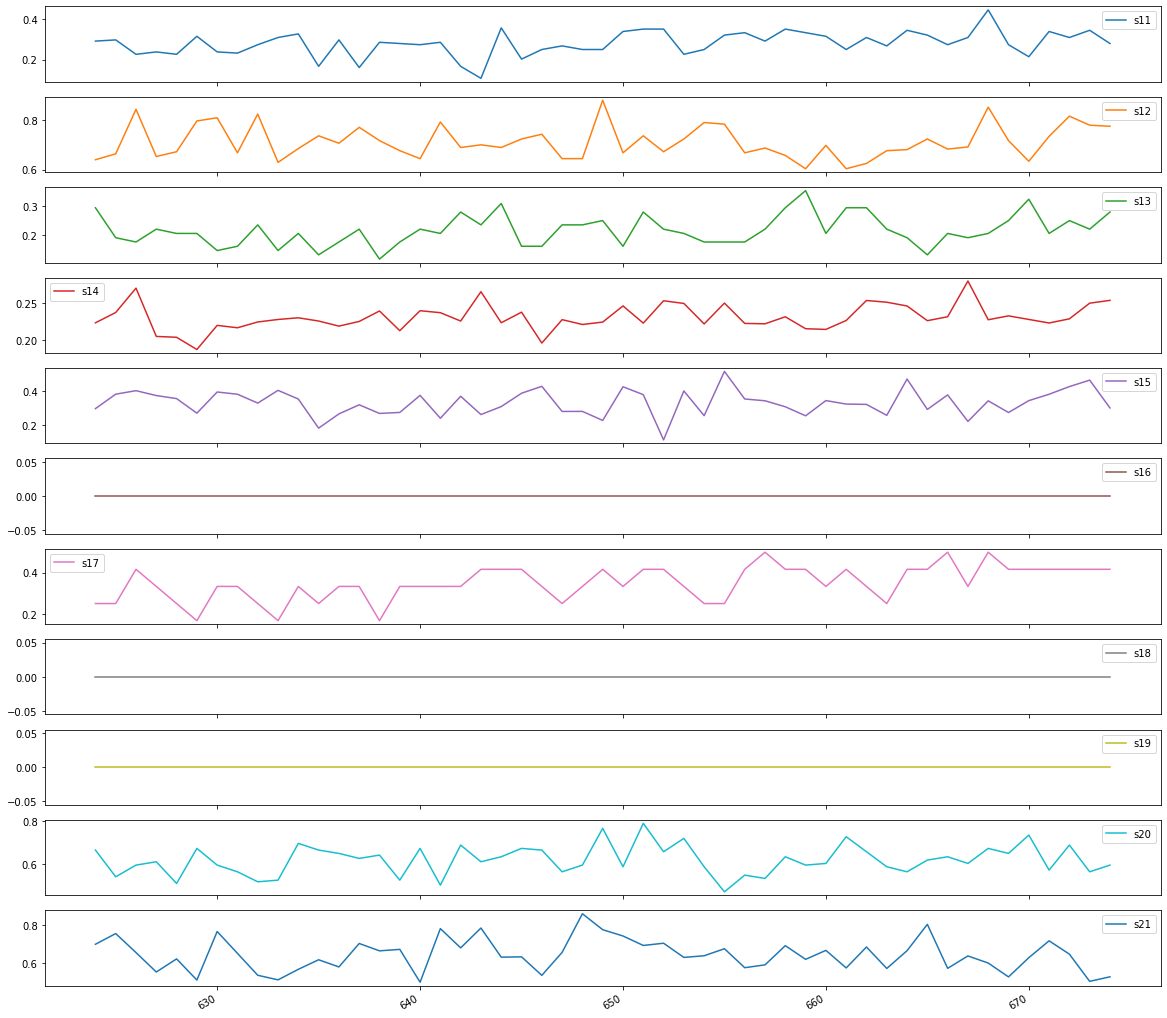

In [13]:
ax2 = engine_id7_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [14]:
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [15]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

## LSTM-нейронная сеть
### Построение нейронной сети
В качестве вида модели выберем последовательную (Sequential). Далее в ней создадим два слоя LSTM, слой Dropout и полносвязный слой Dense.
Перечислим параметры, которые используются при создании слоёв: 
* **input_shape** - размерность входных значений слоя
* **units** - размер выходных значений слоя
* **return_sequences** - указывает на то, нужно ли возвращать всю последовательность выходных данных для каждого элемента (по одному вектору на каждый шаг)
* **activation** - функция активации
* **loss** - функция потерь
* **optimizer** - оптимизатор
* **metrics** - список метрик, используемых при обучении и тестировании  

Перечислим также используемые методы:
* **add** - добавляет слой в созданную модель
* **compile** - компилирует экземпляр модели

In [0]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Обучение с GPU

In [67]:
%%time
def gpu():
  with tf.device('/device:GPU:0'):
    record = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
  return record
record = gpu()

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 15s 1ms/step - loss: 0.0614 - accuracy: 0.9737 - val_loss: 0.0467 - val_accuracy: 0.9783
Epoch 2/10
14849/14849 [==============================] - 15s 1ms/step - loss: 0.0601 - accuracy: 0.9742 - val_loss: 0.0609 - val_accuracy: 0.9744
CPU times: user 42.7 s, sys: 6.27 s, total: 48.9 s
Wall time: 30.2 s


### Обучение с CPU

In [17]:
%%time
def cpu():
  with tf.device('/cpu:0'):
    record = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
  return record
record = cpu()

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 23s 2ms/step - loss: 0.2470 - accuracy: 0.8999 - val_loss: 0.0719 - val_accuracy: 0.9719
Epoch 2/10
14849/14849 [==============================] - 23s 2ms/step - loss: 0.0858 - accuracy: 0.9650 - val_loss: 0.0551 - val_accuracy: 0.9757
Epoch 3/10
14849/14849 [==============================] - 22s 2ms/step - loss: 0.0731 - accuracy: 0.9691 - val_loss: 0.0574 - val_accuracy: 0.9731
CPU times: user 1min 54s, sys: 6.75 s, total: 2min 1s
Wall time: 1min 9s


### Вывод истории обучения нейронной сети

In [18]:
record.history

{'accuracy': [0.89992595, 0.9649808, 0.96908885],
 'loss': [0.24701623534508382, 0.08582819657948043, 0.0730842449234121],
 'val_accuracy': [0.971867024898529, 0.9757032990455627, 0.9731457829475403],
 'val_loss': [0.07189408251467873, 0.055105861002469766, 0.0574497564307526]}

### Построение графиков зависимости показателей точности и функции потерь

Text(0, 0.5, 'Value')

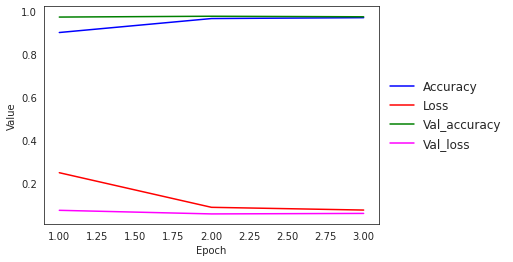

In [19]:
sns.set_style("white")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['accuracy'], color="blue", label="Accuracy")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['loss'], color="red", label="Loss")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['val_accuracy'], color="green", label="Val_accuracy")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['val_loss'], color="magenta", label="Val_loss")
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 12})

plt.xlabel("Epoch")
plt.ylabel("Value")

### Оценка модели на тренировочных данных

In [20]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accuracy: {}'.format(scores[1]))

15631/15631 [==============================] - 6s 397us/step
Accuracy: 0.9611669182777405


15631/15631 [==============================] - 6s 399us/step


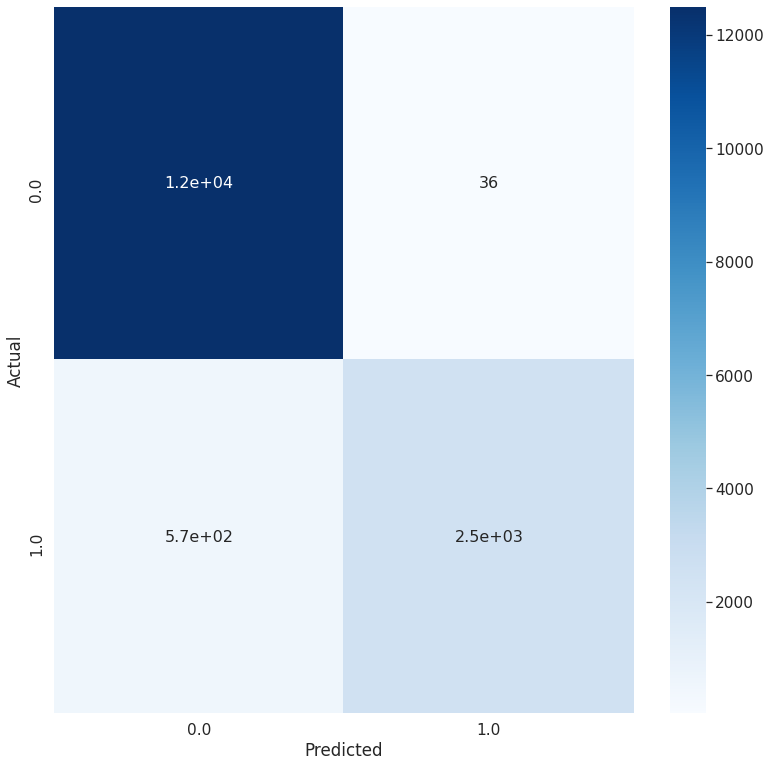

In [21]:
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_true), index=np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13,13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})

In [22]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'precision = ', precision, '\n', 'recall = ', recall, '\n', 'f1 = ', f1)

precision =  0.9859649122807017 
 recall =  0.8158064516129032 
 f1 =  0.8928508384819064


### Оценка модели на тестовых данных

In [23]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print(seq_array_test_last.shape)
print(label_array_test_last.shape)
print('Accuracy: {}'.format(scores_test[1]))

(93, 50, 25)
(93, 1)
Accuracy: 0.9139785170555115


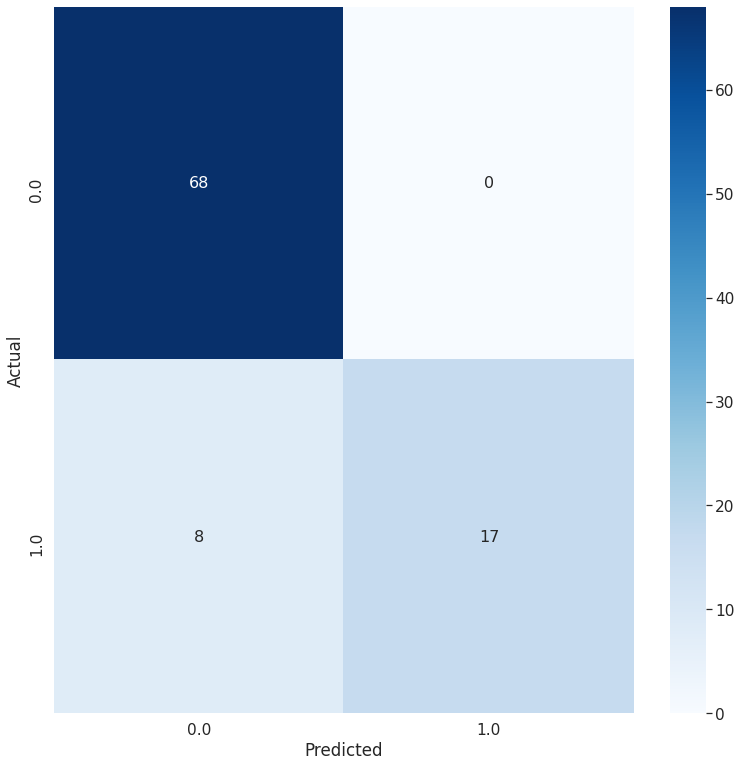

In [24]:
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

cm = confusion_matrix(y_true_test, y_pred_test)
df_cm = pd.DataFrame(cm, columns=np.unique(y_true_test), index=np.unique(y_true_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13,13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})

In [25]:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.68 
 F1-score: 0.8095238095238095


### Запись полученных значений метрик в датафрейм

In [26]:
results_df = pd.DataFrame([[scores[1],precision,recall,f1],
                          [scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM Training',
                                 'LSTM Test'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM Training,0.961167,0.985965,0.815806,0.892851
LSTM Test,0.913979,1.000000,0.680000,0.809524


## RNN+GRU-нейронная сеть
### Построение нейронной сети
В качестве вида модели выберем последовательную (Sequential). Далее в ней создадим слой RNN, слой GRU, слой Dropout и полносвязный слой Dense. 

In [27]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN( 
    input_shape=(sequence_length, nb_features),
    units=100, 
    return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50, 100)           12600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 100,665
Trainable params: 100,665
Non-trainable params: 0
_________________________________________________________________
None


### Обучение модели с использованием GPU-ускорителя

In [68]:
%%time
def gpu():
  with tf.device('/device:GPU:0'):
    record = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
  return record
record = gpu()  

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 16s 1ms/step - loss: 0.0499 - accuracy: 0.9778 - val_loss: 0.0412 - val_accuracy: 0.9821
Epoch 2/10
14849/14849 [==============================] - 15s 1ms/step - loss: 0.0515 - accuracy: 0.9775 - val_loss: 0.0556 - val_accuracy: 0.9731
CPU times: user 43.4 s, sys: 6.34 s, total: 49.7 s
Wall time: 30.7 s


### Обучение модели с использованием CPU

In [28]:
%%time
def cpu():
  with tf.device('/cpu:0'):
    record = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
  return record
record = cpu()

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 25s 2ms/step - loss: 0.2160 - accuracy: 0.9110 - val_loss: 0.1214 - val_accuracy: 0.9386
Epoch 2/10
14849/14849 [==============================] - 25s 2ms/step - loss: 0.1191 - accuracy: 0.9496 - val_loss: 0.1728 - val_accuracy: 0.9258
CPU times: user 1min 28s, sys: 4.91 s, total: 1min 33s
Wall time: 51 s


### Вывод истории обучения нейронной сети

In [29]:
record.history

{'accuracy': [0.91097045, 0.9495589],
 'loss': [0.21603038248796883, 0.11907004179701804],
 'val_accuracy': [0.9386188983917236, 0.9258311986923218],
 'val_loss': [0.12139981611610373, 0.17280446702276198]}

### Построение графиков зависимости показателей точности и функции потерь

Text(0, 0.5, 'Value')

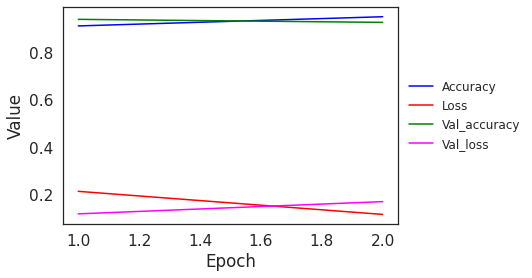

In [30]:
sns.set_style("white")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['accuracy'], color="blue", label="Accuracy")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['loss'], color="red", label="Loss")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['val_accuracy'], color="green", label="Val_accuracy")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['val_loss'], color="magenta", label="Val_loss")
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 12})

plt.xlabel("Epoch")
plt.ylabel("Value")

### Оценка модели на тренировочных данных

In [31]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

15631/15631 [==============================] - 7s 423us/step
Accurracy: 0.9278996586799622


15631/15631 [==============================] - 7s 417us/step


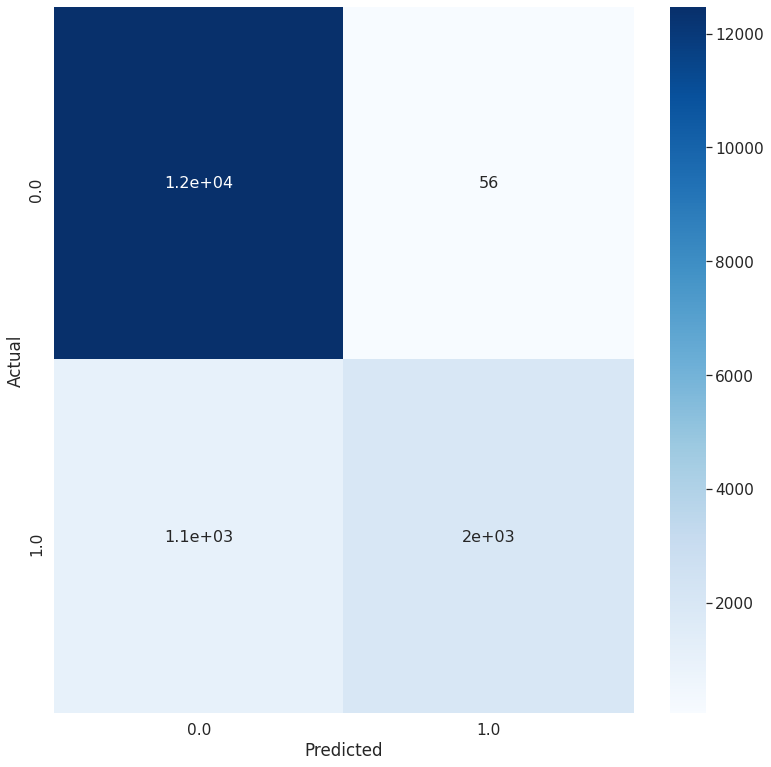

In [32]:
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_true), index=np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13,13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})

In [33]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'precision = ', precision, '\n', 'recall = ', recall, '\n', 'f1 = ', f1)

precision =  0.9731414868105516 
 recall =  0.6545161290322581 
 f1 =  0.7826422372227578


### Оценка модели на тестовых данных

In [34]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accuracy: {}'.format(scores_test[1]))

Accuracy: 0.9032257795333862


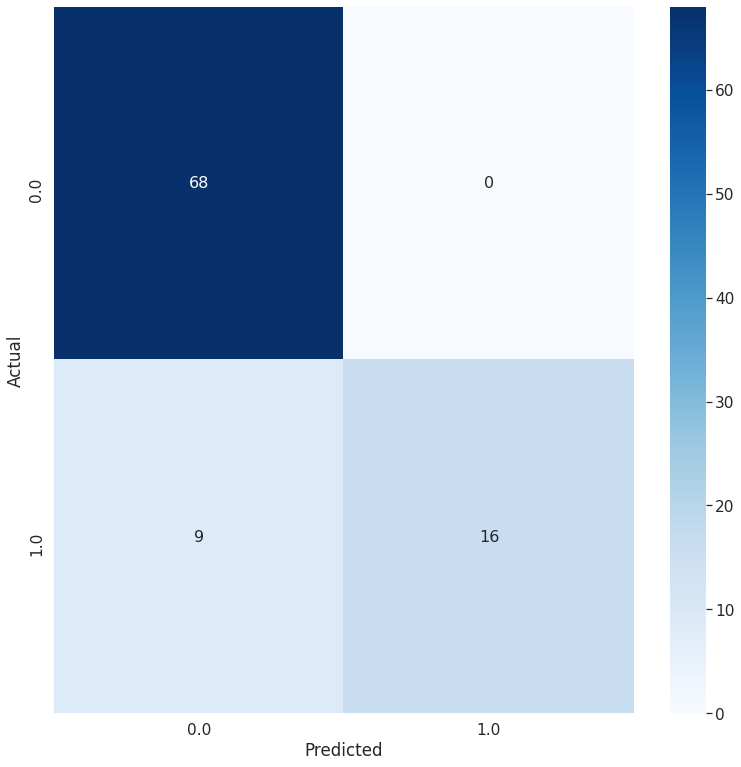

In [35]:
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

cm = confusion_matrix(y_true_test, y_pred_test)
df_cm = pd.DataFrame(cm, columns=np.unique(y_true_test), index=np.unique(y_true_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13,13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})

In [36]:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.64 
 F1-score: 0.7804878048780487


### Запись полученных значений метрик в датафрейм

In [37]:
results_df_1 = pd.DataFrame([[scores[1],precision,recall,f1],
                          [scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN+GRU Training',
                                 'RNN+GRU Test'])
results_df = results_df.append(results_df_1)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM Training,0.961167,0.985965,0.815806,0.892851
LSTM Test,0.913979,1.000000,0.680000,0.809524
RNN+GRU Training,0.927900,0.973141,0.654516,0.782642
RNN+GRU Test,0.903226,1.000000,0.640000,0.780488


## RNN-нейронная сеть
### Построение нейронной сети
В качестве вида модели выберем последовательную (Sequential). Далее в ней создадим два слоя RNN, слой Dropout и полносвязный слой Dense.

In [38]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(SimpleRNN( 
    input_shape=(sequence_length, nb_features),
    units=200, 
    return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN( 
    units=100, 
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 50, 200)           45200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               30100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 75,401
Trainable params: 75,401
Non-trainable params: 0
_________________________________________________________________


### Обучение модели с использованием GPU-ускорителя

In [69]:
%%time
def gpu():
  with tf.device('/device:GPU:0'):
    record = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
  return record
record = gpu()

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 15s 1ms/step - loss: 0.0518 - accuracy: 0.9778 - val_loss: 0.0806 - val_accuracy: 0.9629
Epoch 2/10
14849/14849 [==============================] - 15s 1000us/step - loss: 0.0470 - accuracy: 0.9791 - val_loss: 0.0472 - val_accuracy: 0.9834
Epoch 3/10
14849/14849 [==============================] - 15s 1ms/step - loss: 0.0452 - accuracy: 0.9800 - val_loss: 0.0395 - val_accuracy: 0.9834
Epoch 4/10
14849/14849 [==============================] - 15s 1ms/step - loss: 0.0476 - accuracy: 0.9799 - val_loss: 0.0488 - val_accuracy: 0.9847
CPU times: user 1min 25s, sys: 12.6 s, total: 1min 37s
Wall time: 60 s


### Обучение модели с использованием CPU

In [39]:
%%time
def cpu():
  with tf.device('/cpu:0'):
    record = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
  return record
record = cpu()

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 14s 945us/step - loss: 0.2213 - accuracy: 0.9059 - val_loss: 0.1113 - val_accuracy: 0.9540
Epoch 2/10
14849/14849 [==============================] - 14s 912us/step - loss: 0.1316 - accuracy: 0.9446 - val_loss: 0.1541 - val_accuracy: 0.9284
CPU times: user 48 s, sys: 2.15 s, total: 50.2 s
Wall time: 28.5 s


### Вывод истории обучения нейронной сети

In [40]:
record.history

{'accuracy': [0.90585226, 0.94457537],
 'loss': [0.22127482580334998, 0.13159243385674085],
 'val_accuracy': [0.9539641737937927, 0.928388774394989],
 'val_loss': [0.1112961571311097, 0.1540819971686434]}

### Построение графиков зависимости показателей точности и функции потерь

Text(0, 0.5, 'Value')

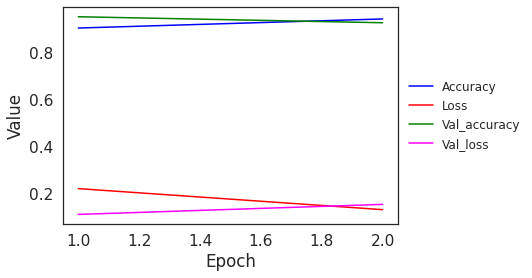

In [41]:
sns.set_style("white")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['accuracy'], color="blue", label="Accuracy")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['loss'], color="red", label="Loss")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['val_accuracy'], color="green", label="Val_accuracy")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['val_loss'], color="magenta", label="Val_loss")
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 12})

plt.xlabel("Epoch")
plt.ylabel("Value")

### Оценка модели на тренировочных данных

In [42]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

15631/15631 [==============================] - 5s 303us/step
Accurracy: 0.9226536750793457


15631/15631 [==============================] - 5s 308us/step


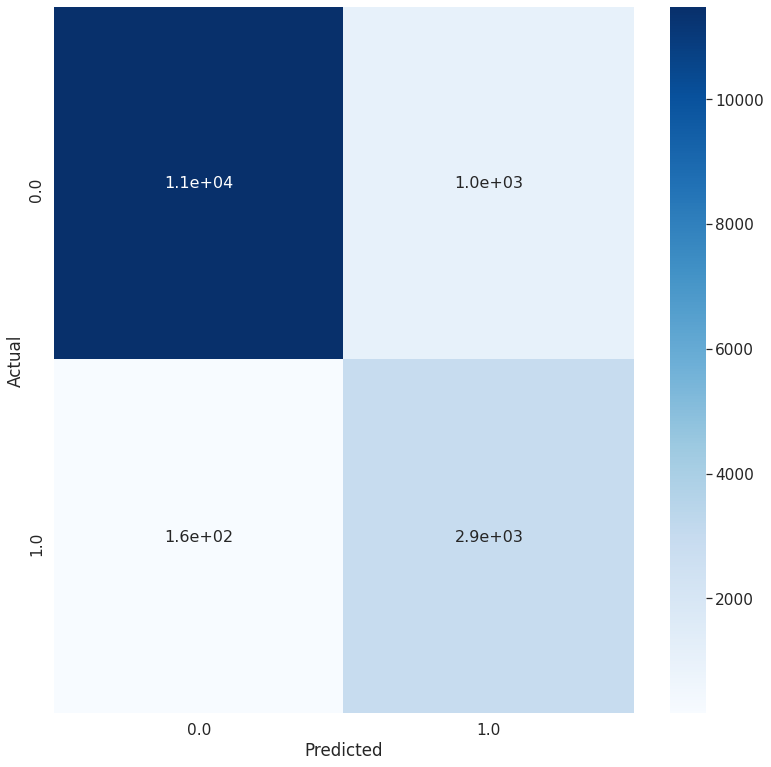

In [43]:
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_true), index=np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13,13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})

In [44]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'precision = ', precision, '\n', 'recall = ', recall, '\n', 'f1 = ', f1)

precision =  0.7369080430969682 
 recall =  0.9487096774193549 
 f1 =  0.8295021858694119


### Оценка модели на тестовых данных

In [45]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accuracy: {}'.format(scores_test[1]))

Accuracy: 0.8924731016159058


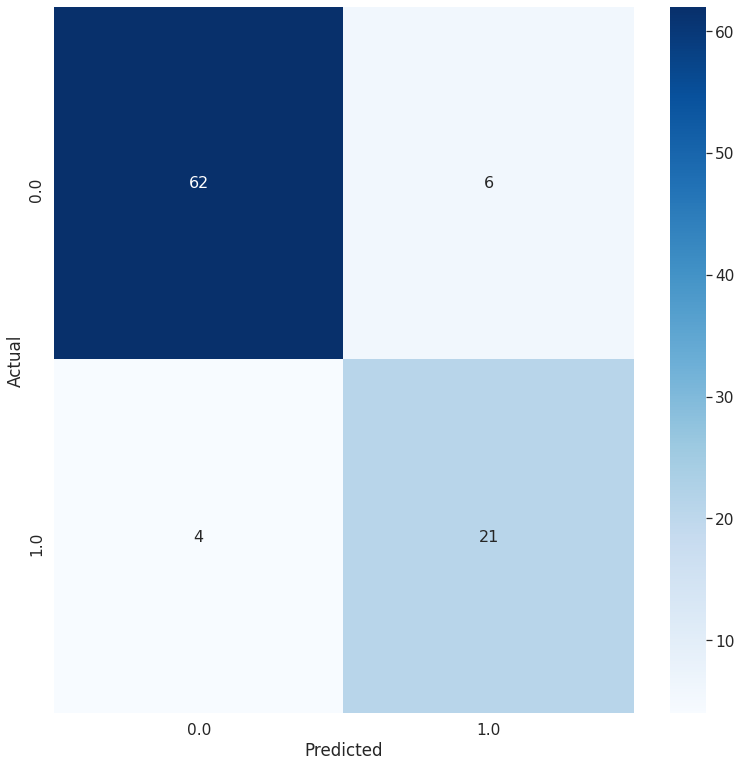

In [46]:
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

cm = confusion_matrix(y_true_test, y_pred_test)
df_cm = pd.DataFrame(cm, columns=np.unique(y_true_test), index=np.unique(y_true_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13,13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})

In [47]:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  0.7777777777777778 
 Recall:  0.84 
 F1-score: 0.8076923076923077


### Запись полученных значений метрик в датафрейм

In [48]:
results_df_2 = pd.DataFrame([[scores[1],precision,recall,f1],
                          [scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['RNN Training',
                                 'RNN Test'])
results_df = results_df.append(results_df_2)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM Training,0.961167,0.985965,0.815806,0.892851
LSTM Test,0.913979,1.000000,0.680000,0.809524
RNN+GRU Training,0.927900,0.973141,0.654516,0.782642
RNN+GRU Test,0.903226,1.000000,0.640000,0.780488
RNN Training,0.922654,0.736908,0.948710,0.829502
RNN Test,0.892473,0.777778,0.840000,0.807692


## GRU-нейронная сеть
### Построение нейронной сети
В качестве вида модели выберем последовательную (Sequential). Далее в ней создадим два слоя GRU, слой Dropout и полносвязный слой Dense.

In [49]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(GRU( 
    input_shape=(sequence_length, nb_features),
    units=100, 
    return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU( 
    units=100, 
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 50, 100)           37800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 98,201
Trainable params: 98,201
Non-trainable params: 0
_________________________________________________________________


### Обучение модели с использованием GPU-ускорителя

In [70]:
%%time
def gpu():
  with tf.device('/device:GPU:0'):
    record = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
  return record
record = gpu()

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 15s 997us/step - loss: 0.0465 - accuracy: 0.9793 - val_loss: 0.0662 - val_accuracy: 0.9668
Epoch 2/10
14849/14849 [==============================] - 15s 997us/step - loss: 0.0471 - accuracy: 0.9795 - val_loss: 0.0605 - val_accuracy: 0.9706
Epoch 3/10
14849/14849 [==============================] - 15s 1ms/step - loss: 0.0480 - accuracy: 0.9797 - val_loss: 0.0420 - val_accuracy: 0.9821
Epoch 4/10
14849/14849 [==============================] - 15s 1ms/step - loss: 0.0408 - accuracy: 0.9832 - val_loss: 0.0402 - val_accuracy: 0.9795
Epoch 5/10
14849/14849 [==============================] - 15s 999us/step - loss: 0.0387 - accuracy: 0.9827 - val_loss: 0.0476 - val_accuracy: 0.9783
CPU times: user 1min 48s, sys: 15.8 s, total: 2min 4s
Wall time: 1min 14s


### Обучение модели с использованием CPU

In [50]:
%%time
def cpu():
  with tf.device('/cpu:0'):
    record = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
  return record
record = cpu()

Train on 14849 samples, validate on 782 samples
Epoch 1/10
14849/14849 [==============================] - 29s 2ms/step - loss: 0.2335 - accuracy: 0.9036 - val_loss: 0.1474 - val_accuracy: 0.9322
Epoch 2/10
14849/14849 [==============================] - 28s 2ms/step - loss: 0.1295 - accuracy: 0.9446 - val_loss: 0.1179 - val_accuracy: 0.9399
Epoch 3/10
14849/14849 [==============================] - 29s 2ms/step - loss: 0.0852 - accuracy: 0.9623 - val_loss: 0.0736 - val_accuracy: 0.9680
Epoch 4/10
14849/14849 [==============================] - 29s 2ms/step - loss: 0.0635 - accuracy: 0.9730 - val_loss: 0.0524 - val_accuracy: 0.9783
Epoch 5/10
14849/14849 [==============================] - 29s 2ms/step - loss: 0.0619 - accuracy: 0.9738 - val_loss: 0.0729 - val_accuracy: 0.9642
CPU times: user 4min 18s, sys: 13.5 s, total: 4min 31s
Wall time: 2min 25s


### Вывод истории обучения нейронной сети

In [51]:
record.history

{'accuracy': [0.9036299, 0.94457537, 0.962287, 0.9729948, 0.9738029],
 'loss': [0.23350542281177986,
  0.1294709521055591,
  0.08518719745510009,
  0.06345880759734562,
  0.06188001449007451],
 'val_accuracy': [0.9322250485420227,
  0.9398977160453796,
  0.9680306911468506,
  0.97826087474823,
  0.9641943573951721],
 'val_loss': [0.14735185958997674,
  0.11792503617456197,
  0.07362043415493977,
  0.05238680379784397,
  0.07285021194626036]}

### Построение графиков зависимости показателей точности и функции потерь

Text(0, 0.5, 'Value')

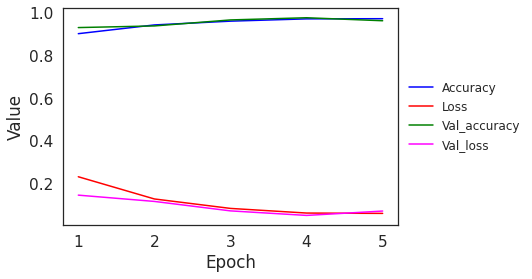

In [52]:
sns.set_style("white")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['accuracy'], color="blue", label="Accuracy")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['loss'], color="red", label="Loss")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['val_accuracy'], color="green", label="Val_accuracy")
plt.plot(range(1, len(record.history['accuracy']) + 1), record.history['val_loss'], color="magenta", label="Val_loss")
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 12})

plt.xlabel("Epoch")
plt.ylabel("Value")

### Оценка модели на тренировочных данных

In [53]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

15631/15631 [==============================] - 7s 428us/step
Accurracy: 0.9726185202598572


15631/15631 [==============================] - 7s 445us/step


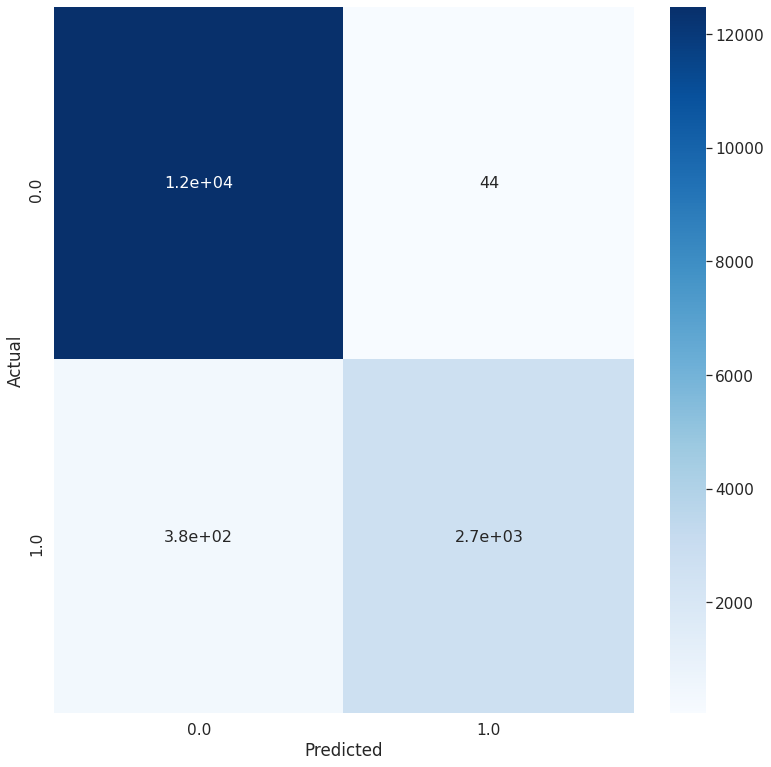

In [54]:
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_true), index=np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13,13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})

In [55]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'precision = ', precision, '\n', 'recall = ', recall, '\n', 'f1 = ', f1)

precision =  0.9840579710144928 
 recall =  0.8761290322580645 
 f1 =  0.926962457337884


### Оценка модели на тестовых данных

In [56]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accuracy: {}'.format(scores_test[1]))

Accuracy: 0.9677419066429138


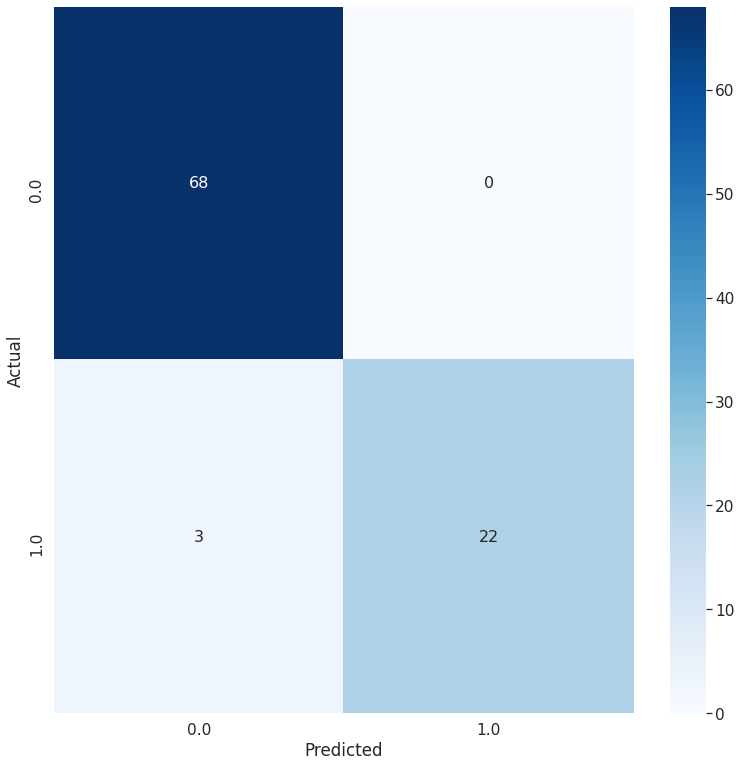

In [57]:
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last

cm = confusion_matrix(y_true_test, y_pred_test)
df_cm = pd.DataFrame(cm, columns=np.unique(y_true_test), index=np.unique(y_true_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(13,13))
sns.set(font_scale=1.4)
ax = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={'size': 16})

In [58]:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.88 
 F1-score: 0.9361702127659575


### Запись полученных значений метрик в датафрейм

In [59]:
results_df_3 = pd.DataFrame([[scores[1],precision,recall,f1],
                          [scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU Training',
                                 'GRU Test'])
results_df = results_df.append(results_df_3)
results_df

,Accuracy,Precision,Recall,F1-score
LSTM Training,0.961167,0.985965,0.815806,0.892851
LSTM Test,0.913979,1.000000,0.680000,0.809524
RNN+GRU Training,0.927900,0.973141,0.654516,0.782642
RNN+GRU Test,0.903226,1.000000,0.640000,0.780488
RNN Training,0.922654,0.736908,0.948710,0.829502
RNN Test,0.892473,0.777778,0.840000,0.807692
GRU Training,0.972619,0.984058,0.876129,0.926962
GRU Test,0.967742,1.000000,0.880000,0.936170


## Сравнение полученных моделей нейронных сетей
Для сравнения полученных моделей построим столбчатые диаграммы со значениями метрик, которые были использованы для оценки результатов

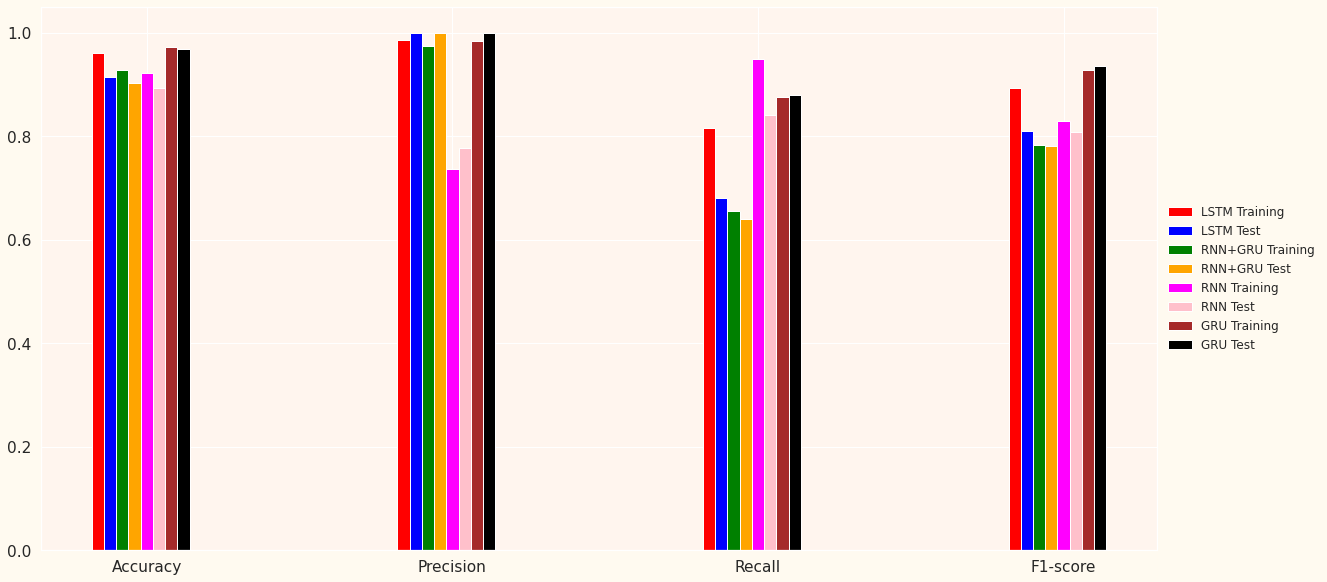

In [60]:
width = 0.04
x = np.arange(len(results_df.loc['LSTM Training']))

fig, ax = plt.subplots()
plt.bar(x - (width * 4), list(results_df.loc['LSTM Training']), width=width, label='LSTM Training', color='red')
plt.bar(x - (width * 3), list(results_df.loc['LSTM Test']), width=width, label='LSTM Test', color='blue')
plt.bar(x - (width * 2), list(results_df.loc['RNN+GRU Training']), width=width, label='RNN+GRU Training', color='green')
plt.bar(x - width, list(results_df.loc['RNN+GRU Test']), width=width, label='RNN+GRU Test', color='orange')
plt.bar(x, list(results_df.loc['RNN Training']), width=width, label='RNN Training', color='magenta')
plt.bar(x + width, list(results_df.loc['RNN Test']), width=width, label='RNN Test', color='pink')
plt.bar(x + (width * 2), list(results_df.loc['GRU Training']), width=width, label='GRU Training', color='brown')
plt.bar(x + (width * 3), list(results_df.loc['GRU Test']), width=width, label='GRU Test', color='black')

fig.set_figwidth(20)
fig.set_figheight(10)
ax.set_xticks(x)
ax.set_xticklabels(list(results_df.columns))
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 12})

## Оценка времени обучения нейронных сетей с применением GRU-ускорителя и с CPU
Для сравнения времени разработки также построим столбчатые диаграммы со значениями времени обучения для каждой модели нейронной сети

In [0]:
time_dict = {'LSTM': [40.8, 244], 'RNN+GRU':[32.8, 138], 'RNN':[29.6, 50.1], 'GRU':[148, 214]}

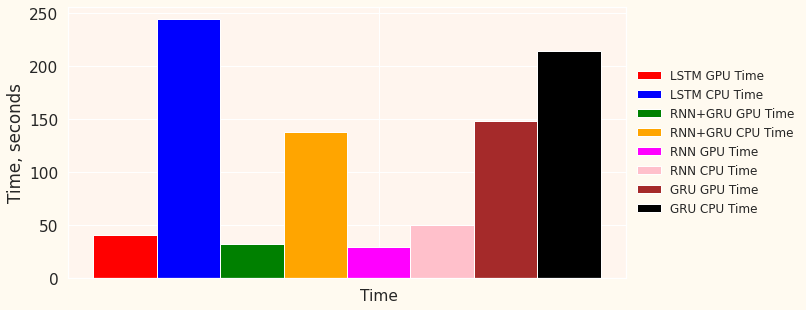

In [62]:
width = 0.04
x = np.arange(1)

fig, ax = plt.subplots()
plt.bar(x - (width * 4), time_dict['LSTM'][0], width=width, label='LSTM GPU Time', color='red')
plt.bar(x - (width * 3), time_dict['LSTM'][1], width=width, label='LSTM CPU Time', color='blue')
plt.bar(x - (width * 2), time_dict['RNN+GRU'][0], width=width, label='RNN+GRU GPU Time', color='green')
plt.bar(x - width, time_dict['RNN+GRU'][1], width=width, label='RNN+GRU CPU Time', color='orange')
plt.bar(x, time_dict['RNN'][0], width=width, label='RNN GPU Time', color='magenta')
plt.bar(x + width, time_dict['RNN'][1], width=width, label='RNN CPU Time', color='pink')
plt.bar(x + (width * 2), time_dict['GRU'][0], width=width, label='GRU GPU Time', color='brown')
plt.bar(x + (width * 3), time_dict['GRU'][1], width=width, label='GRU CPU Time', color='black')

fig.set_figwidth(10)
fig.set_figheight(5)
ax.set_xticks(x)
ax.set_xticklabels(['Time'])
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
plt.ylabel("Time, seconds")
plt.legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left",prop={'size': 12})

## Выводы 
Из полученных результатов видно, что наилучшие результаты показала GRU-модель нейронной сети, т.к. именно эта модель имеют наиболее стабильные показатели на каждой из представленных на диаграмме метрик. 
Остальные модели показали приблизительно одинаковые результаты.  

С применением GPU-ускорителя модели обучились быстрее, чем на обычном CPU-процессоре. Наибольшую разницу во времени обучения показала LSTM-модель, а наименьшую - RNN-модель.